In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
from LSTMbis import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

In [2]:
import os
data = {}
a=0
max_len = 0
for j in range(1,7):
    for i in os.listdir('./new_data/%s'%j):
        if i.endswith('.txt'):
            a = a+1
            data['%s'%a] = pd.read_csv('new_data/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ')
            if len(data['%s'%a])/20>max_len:
                max_len=int(len(data['%s'%a])/20)
            

In [4]:
a = 0
inputs = np.zeros([10,len(data),4*max_len])
gt = np.zeros([11,len(data),4])
in_coord = np.zeros([10,len(data),2])
gt_coord = np.zeros([11,len(data),2])

for i in data:
    len_d = np.int(len(data['%s'%i])/20)
    for j in range(len_d):
        inputs[:,a,j*4:(j+1)*4] = data['%s'%i].loc[j*10:(j+1)*10-1,'x':'Vy']
    
    gt[:,a,:] = np.array(data['%s'%i].loc[9:19,['x','y','Vx','Vy']])
    in_coord[:,a,:] = np.array(data['%s'%i].loc[0:9,['x','y']])
    gt_coord[:,a,:] = np.array(data['%s'%i].loc[9:19,['x','y']])
    a +=1


inputs = torch.from_numpy(inputs).float()
gt = torch.from_numpy(gt).float()
inputs = inputs.permute([1,0,2])
gt = gt.permute([1,0,2])



In [5]:
inputs.shape, gt.shape

(torch.Size([4926, 10, 72]), torch.Size([4926, 11, 4]))

In [7]:
from torch import optim

lr = 0.01
lstm = LSTM(4*max_len)
optimizer = optim.SGD(lstm.parameters(), lr=lr)
criterion = nn.MSELoss()

In [9]:
traindataset = utils.TensorDataset(inputs, gt[:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=2, shuffle=True)

epochs = 70
steps = 0
print_every = 200
running_loss = 0 #### DOD

for e in range(epochs):
    start = time.time()
    if (e+1)%5==0:
        lr /= 5
        optimizer = optim.SGD(lstm.parameters(), lr=0.005)

    for train_coord, ground_tru in iter(trainloader):
        steps += 1
        
        train_coord = train_coord.permute([1,0,2])
        ground_tru = ground_tru.permute([1,0,2])

        in_train = Variable(train_coord)
        targets = Variable(ground_tru)
        optimizer.zero_grad()
        #print(in_train.shape)
        #print(targets.shape)
        #pdb.set_trace()
        out = lstm.forward(in_train)
        out_bis = out[:,:,0:2].clone()
        #print(out_bis.shape)    
        for i in range(10):
            if i == 0:
                out_bis[i, :, 0:2] = in_train[-1, :, 0:2] + out[i, :, 2:]*0.4
            else:
                out_bis[i, :, 0:2] = out[i - 1, :, 0:2] + out[i, :, 2:]*0.4
        #print(out.shape)
        loss = criterion(out, targets) + criterion(out_bis, targets[:,:,0:2])+ 2*criterion()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]

    
        if steps % print_every == 0:
                stop = time.time()
                print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch".format((stop - start)/print_every),
                  "{:.8f} lr".format(lr)
                 )
                running_loss = 0
                start = time.time()

/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/70.. Loss: 2.3511.. 0.0044 s/batch 0.01000000 lr
Epoch: 1/70.. Loss: 1.9032.. 0.0043 s/batch 0.01000000 lr
Epoch: 1/70.. Loss: 1.9641.. 0.0041 s/batch 0.01000000 lr
Epoch: 1/70.. Loss: 1.4494.. 0.0040 s/batch 0.01000000 lr
Epoch: 1/70.. Loss: 1.5460.. 0.0045 s/batch 0.01000000 lr
Epoch: 1/70.. Loss: 1.2116.. 0.0035 s/batch 0.01000000 lr
Epoch: 1/70.. Loss: 0.9622.. 0.0049 s/batch 0.01000000 lr
Epoch: 1/70.. Loss: 1.0921.. 0.0033 s/batch 0.01000000 lr
Epoch: 1/70.. Loss: 0.8326.. 0.0047 s/batch 0.01000000 lr
Epoch: 1/70.. Loss: 0.5815.. 0.0040 s/batch 0.01000000 lr
Epoch: 1/70.. Loss: 0.8004.. 0.0047 s/batch 0.01000000 lr
Epoch: 1/70.. Loss: 0.8250.. 0.0046 s/batch 0.01000000 lr
Epoch: 2/70.. Loss: 0.7057.. 0.0028 s/batch 0.01000000 lr
Epoch: 2/70.. Loss: 0.8558.. 0.0046 s/batch 0.01000000 lr
Epoch: 2/70.. Loss: 0.6846.. 0.0045 s/batch 0.01000000 lr
Epoch: 2/70.. Loss: 0.6536.. 0.0035 s/batch 0.01000000 lr
Epoch: 2/70.. Loss: 0.8132.. 0.0045 s/batch 0.01000000 lr
Epoch: 2/70.. 

Epoch: 12/70.. Loss: 0.5424.. 0.0042 s/batch 0.00040000 lr
Epoch: 12/70.. Loss: 0.4709.. 0.0039 s/batch 0.00040000 lr
Epoch: 12/70.. Loss: 0.5202.. 0.0039 s/batch 0.00040000 lr
Epoch: 12/70.. Loss: 0.4780.. 0.0043 s/batch 0.00040000 lr
Epoch: 12/70.. Loss: 0.7066.. 0.0037 s/batch 0.00040000 lr
Epoch: 12/70.. Loss: 0.5292.. 0.0042 s/batch 0.00040000 lr
Epoch: 13/70.. Loss: 0.5779.. 0.0006 s/batch 0.00040000 lr
Epoch: 13/70.. Loss: 0.5385.. 0.0047 s/batch 0.00040000 lr
Epoch: 13/70.. Loss: 0.4402.. 0.0038 s/batch 0.00040000 lr
Epoch: 13/70.. Loss: 0.6306.. 0.0049 s/batch 0.00040000 lr
Epoch: 13/70.. Loss: 0.5916.. 0.0036 s/batch 0.00040000 lr
Epoch: 13/70.. Loss: 0.6154.. 0.0046 s/batch 0.00040000 lr
Epoch: 13/70.. Loss: 0.5169.. 0.0039 s/batch 0.00040000 lr
Epoch: 13/70.. Loss: 0.4051.. 0.0044 s/batch 0.00040000 lr
Epoch: 13/70.. Loss: 0.6050.. 0.0037 s/batch 0.00040000 lr
Epoch: 13/70.. Loss: 0.5644.. 0.0046 s/batch 0.00040000 lr
Epoch: 13/70.. Loss: 0.4501.. 0.0035 s/batch 0.00040000 

Epoch: 23/70.. Loss: 0.4423.. 0.0041 s/batch 0.00001600 lr
Epoch: 23/70.. Loss: 0.4667.. 0.0039 s/batch 0.00001600 lr
Epoch: 23/70.. Loss: 0.5127.. 0.0045 s/batch 0.00001600 lr
Epoch: 24/70.. Loss: 0.5960.. 0.0029 s/batch 0.00001600 lr
Epoch: 24/70.. Loss: 0.6298.. 0.0045 s/batch 0.00001600 lr
Epoch: 24/70.. Loss: 0.3491.. 0.0038 s/batch 0.00001600 lr
Epoch: 24/70.. Loss: 0.4386.. 0.0045 s/batch 0.00001600 lr
Epoch: 24/70.. Loss: 0.5192.. 0.0045 s/batch 0.00001600 lr
Epoch: 24/70.. Loss: 0.3992.. 0.0035 s/batch 0.00001600 lr
Epoch: 24/70.. Loss: 0.6237.. 0.0049 s/batch 0.00001600 lr
Epoch: 24/70.. Loss: 0.5479.. 0.0038 s/batch 0.00001600 lr
Epoch: 24/70.. Loss: 0.5295.. 0.0047 s/batch 0.00001600 lr
Epoch: 24/70.. Loss: 0.5186.. 0.0035 s/batch 0.00001600 lr
Epoch: 24/70.. Loss: 0.4463.. 0.0047 s/batch 0.00001600 lr
Epoch: 24/70.. Loss: 0.4765.. 0.0042 s/batch 0.00001600 lr
Epoch: 25/70.. Loss: 0.5643.. 0.0013 s/batch 0.00000320 lr
Epoch: 25/70.. Loss: 0.4345.. 0.0047 s/batch 0.00000320 

Epoch: 35/70.. Loss: 0.3453.. 0.0040 s/batch 0.00000013 lr
Epoch: 35/70.. Loss: 0.4646.. 0.0038 s/batch 0.00000013 lr
Epoch: 35/70.. Loss: 0.4520.. 0.0045 s/batch 0.00000013 lr
Epoch: 35/70.. Loss: 0.5270.. 0.0033 s/batch 0.00000013 lr
Epoch: 35/70.. Loss: 0.5379.. 0.0048 s/batch 0.00000013 lr
Epoch: 35/70.. Loss: 0.4909.. 0.0035 s/batch 0.00000013 lr
Epoch: 35/70.. Loss: 0.4816.. 0.0050 s/batch 0.00000013 lr
Epoch: 35/70.. Loss: 0.5027.. 0.0044 s/batch 0.00000013 lr
Epoch: 35/70.. Loss: 0.4319.. 0.0035 s/batch 0.00000013 lr
Epoch: 35/70.. Loss: 0.4774.. 0.0034 s/batch 0.00000013 lr
Epoch: 35/70.. Loss: 0.5185.. 0.0036 s/batch 0.00000013 lr
Epoch: 35/70.. Loss: 0.5784.. 0.0034 s/batch 0.00000013 lr
Epoch: 36/70.. Loss: 0.5032.. 0.0034 s/batch 0.00000013 lr
Epoch: 36/70.. Loss: 0.4059.. 0.0036 s/batch 0.00000013 lr
Epoch: 36/70.. Loss: 0.5907.. 0.0037 s/batch 0.00000013 lr
Epoch: 36/70.. Loss: 0.4565.. 0.0052 s/batch 0.00000013 lr
Epoch: 36/70.. Loss: 0.5601.. 0.0043 s/batch 0.00000013 

Epoch: 46/70.. Loss: 0.3990.. 0.0043 s/batch 0.00000001 lr
Epoch: 46/70.. Loss: 0.3857.. 0.0044 s/batch 0.00000001 lr
Epoch: 46/70.. Loss: 0.5394.. 0.0047 s/batch 0.00000001 lr
Epoch: 46/70.. Loss: 0.4692.. 0.0048 s/batch 0.00000001 lr
Epoch: 46/70.. Loss: 0.5692.. 0.0094 s/batch 0.00000001 lr
Epoch: 46/70.. Loss: 0.4725.. 0.0048 s/batch 0.00000001 lr
Epoch: 46/70.. Loss: 0.4358.. 0.0036 s/batch 0.00000001 lr
Epoch: 46/70.. Loss: 0.4719.. 0.0038 s/batch 0.00000001 lr
Epoch: 47/70.. Loss: 0.4761.. 0.0019 s/batch 0.00000001 lr
Epoch: 47/70.. Loss: 0.5716.. 0.0040 s/batch 0.00000001 lr
Epoch: 47/70.. Loss: 0.5148.. 0.0036 s/batch 0.00000001 lr
Epoch: 47/70.. Loss: 0.5122.. 0.0035 s/batch 0.00000001 lr
Epoch: 47/70.. Loss: 0.4541.. 0.0058 s/batch 0.00000001 lr
Epoch: 47/70.. Loss: 0.4066.. 0.0034 s/batch 0.00000001 lr
Epoch: 47/70.. Loss: 0.5495.. 0.0055 s/batch 0.00000001 lr
Epoch: 47/70.. Loss: 0.4326.. 0.0060 s/batch 0.00000001 lr
Epoch: 47/70.. Loss: 0.4162.. 0.0076 s/batch 0.00000001 

Epoch: 57/70.. Loss: 0.5601.. 0.0074 s/batch 0.00000000 lr
Epoch: 57/70.. Loss: 0.5692.. 0.0084 s/batch 0.00000000 lr
Epoch: 57/70.. Loss: 0.3902.. 0.0064 s/batch 0.00000000 lr
Epoch: 57/70.. Loss: 0.5145.. 0.0040 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.4261.. 0.0002 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.5799.. 0.0040 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.3971.. 0.0036 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.3541.. 0.0045 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.5752.. 0.0038 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.4396.. 0.0044 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.3697.. 0.0036 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.4489.. 0.0039 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.3620.. 0.0038 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.4490.. 0.0044 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.4174.. 0.0048 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.5964.. 0.0040 s/batch 0.00000000 lr
Epoch: 58/70.. Loss: 0.4545.. 0.0044 s/batch 0.00000000 

Epoch: 68/70.. Loss: 0.4521.. 0.0067 s/batch 0.00000000 lr
Epoch: 69/70.. Loss: 0.5349.. 0.0029 s/batch 0.00000000 lr
Epoch: 69/70.. Loss: 0.5306.. 0.0053 s/batch 0.00000000 lr
Epoch: 69/70.. Loss: 0.4176.. 0.0048 s/batch 0.00000000 lr
Epoch: 69/70.. Loss: 0.5246.. 0.0085 s/batch 0.00000000 lr
Epoch: 69/70.. Loss: 0.3166.. 0.0049 s/batch 0.00000000 lr
Epoch: 69/70.. Loss: 0.4606.. 0.0040 s/batch 0.00000000 lr
Epoch: 69/70.. Loss: 0.5016.. 0.0036 s/batch 0.00000000 lr
Epoch: 69/70.. Loss: 0.3390.. 0.0041 s/batch 0.00000000 lr
Epoch: 69/70.. Loss: 0.5836.. 0.0044 s/batch 0.00000000 lr
Epoch: 69/70.. Loss: 0.4794.. 0.0038 s/batch 0.00000000 lr
Epoch: 69/70.. Loss: 0.4289.. 0.0043 s/batch 0.00000000 lr
Epoch: 69/70.. Loss: 0.4414.. 0.0073 s/batch 0.00000000 lr
Epoch: 70/70.. Loss: 0.4171.. 0.0053 s/batch 0.00000000 lr
Epoch: 70/70.. Loss: 0.4534.. 0.0066 s/batch 0.00000000 lr
Epoch: 70/70.. Loss: 0.3860.. 0.0048 s/batch 0.00000000 lr
Epoch: 70/70.. Loss: 0.4448.. 0.0045 s/batch 0.00000000 

In [10]:
inputs_pred = inputs.permute([1,0,2])
output_final = lstm.predict(inputs_pred)
output_final = output_final.data.numpy()

## Post processing step
Go back to coordinate:
We have Vx and Vy and we want x and y.
$ V = d/t$
$ d = V*t$
Here t = 0.4s between each point.
Start from data at index 9. Then we add d_x and d_y to the last x and y.

In [11]:
output_final.shape

(10, 4926, 4)

In [16]:
output_coord=np.zeros([11,len(data),2])
for j in range(11):
    for i in range(len(data)):
        if j==0:
            output_coord[j,i,0:2] = in_coord[9,i,0:2]
        else:
            output_coord[j,i,0:2] = output_final[j-1,i,0:2]+output_final[j-1,i,2:]*0.4
        

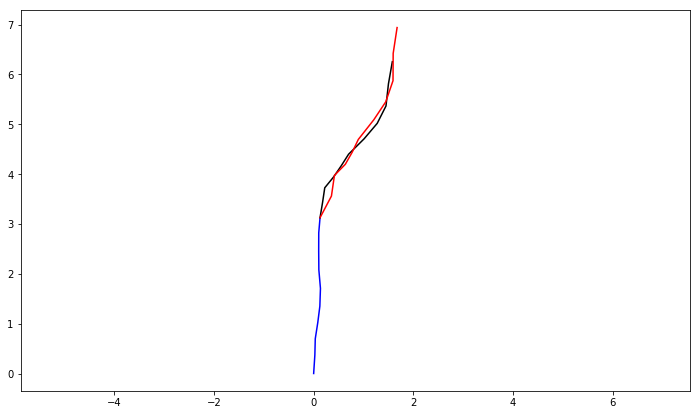

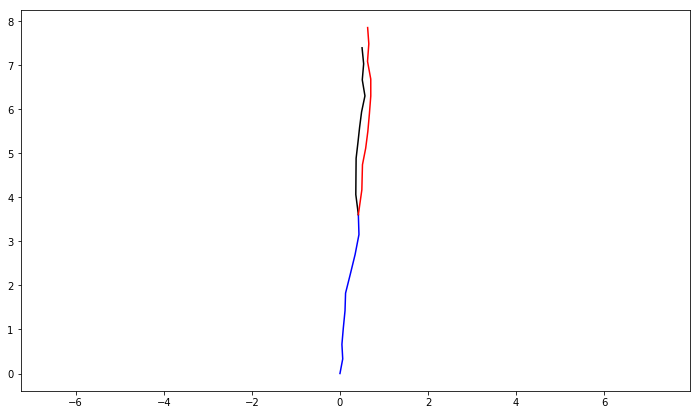

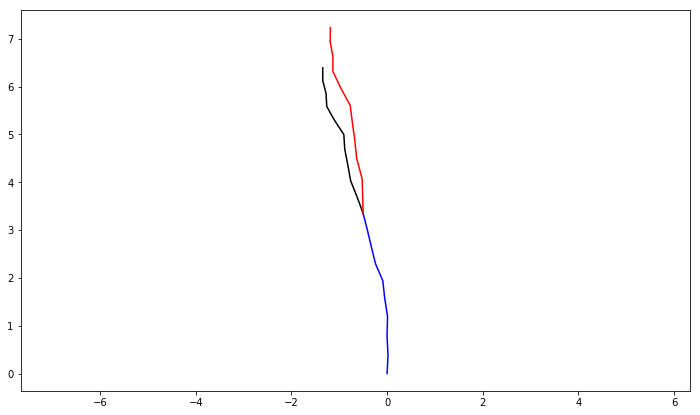

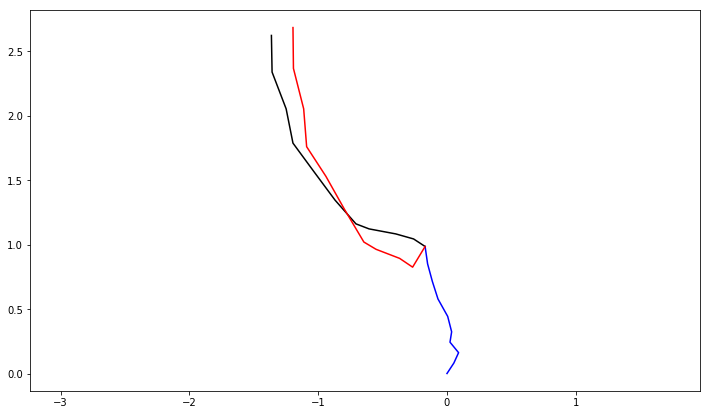

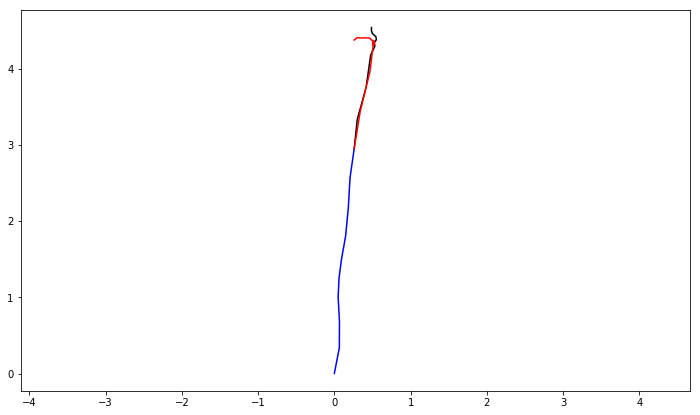

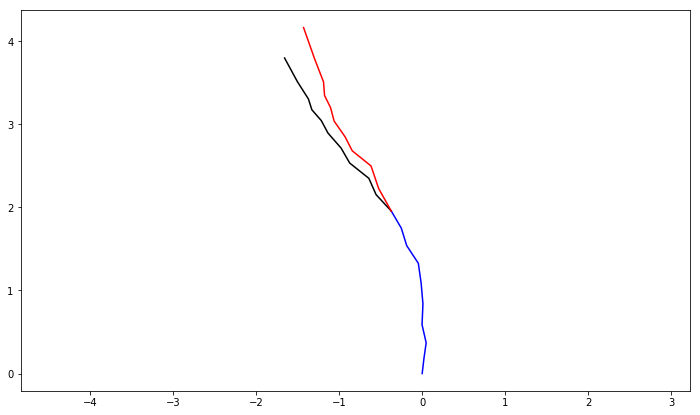

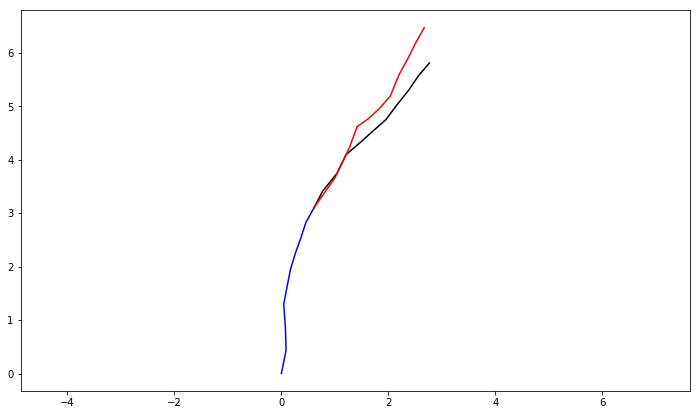

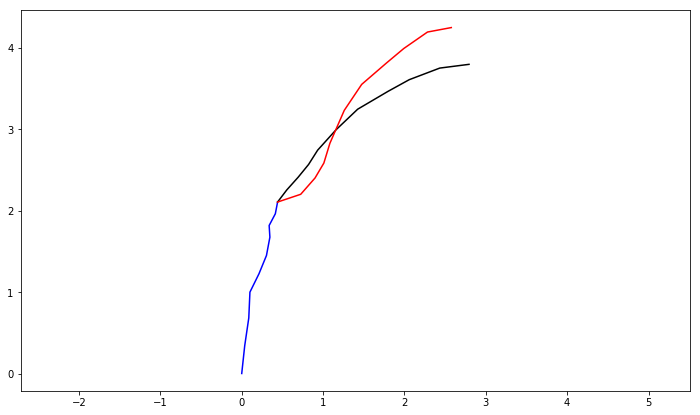

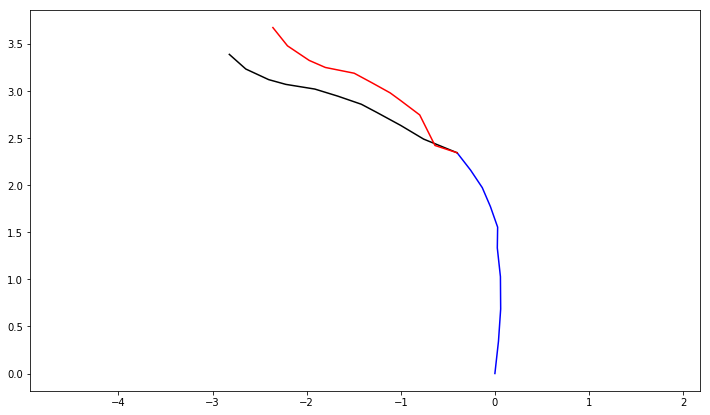

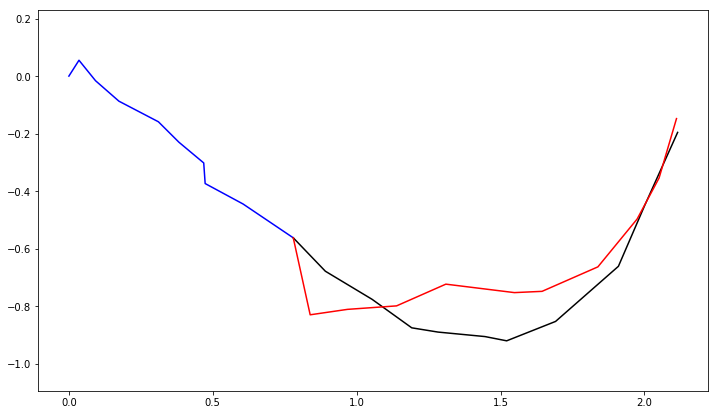

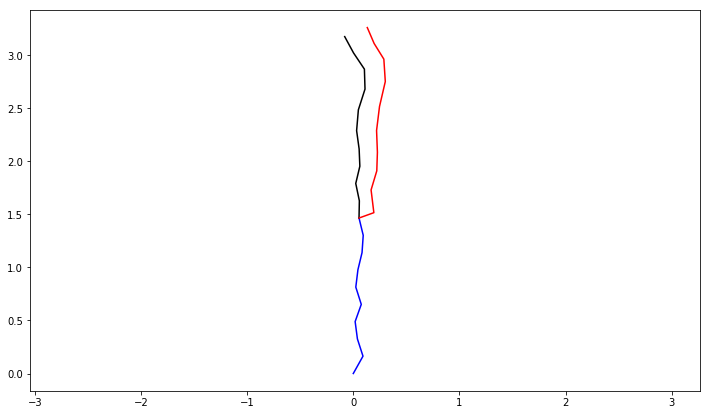

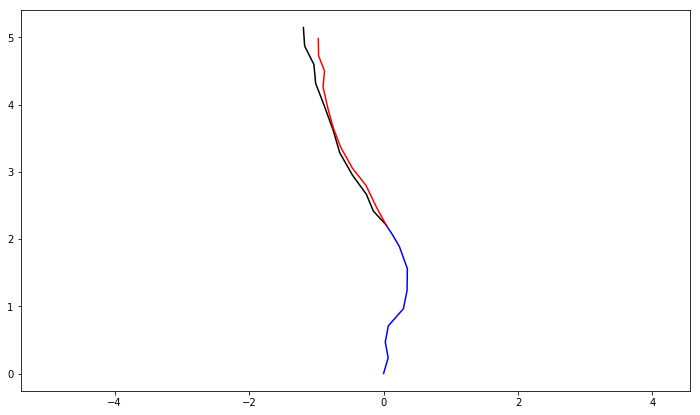

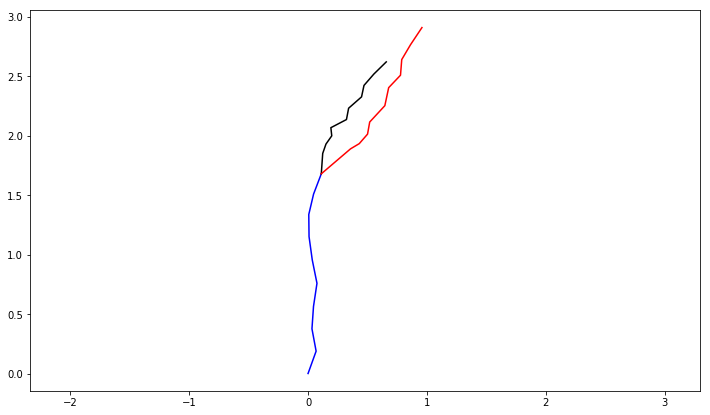

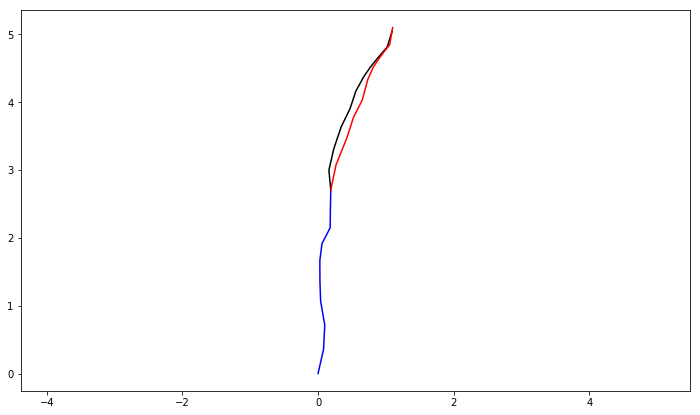

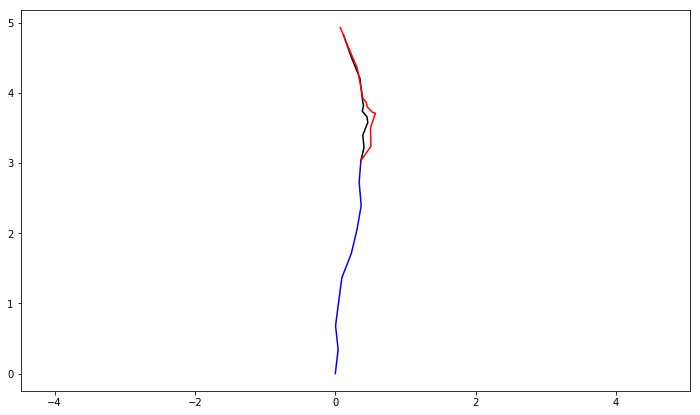

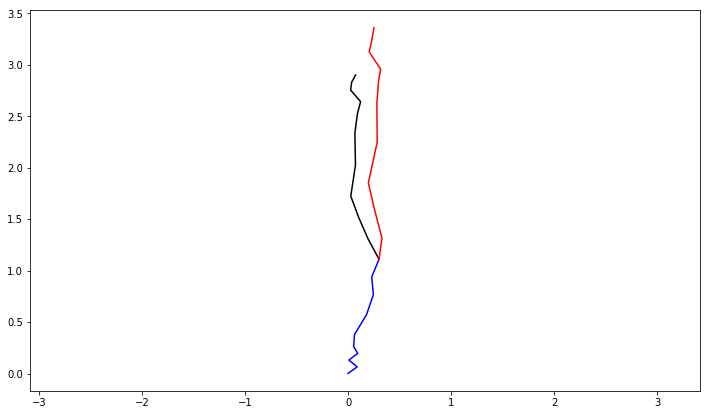

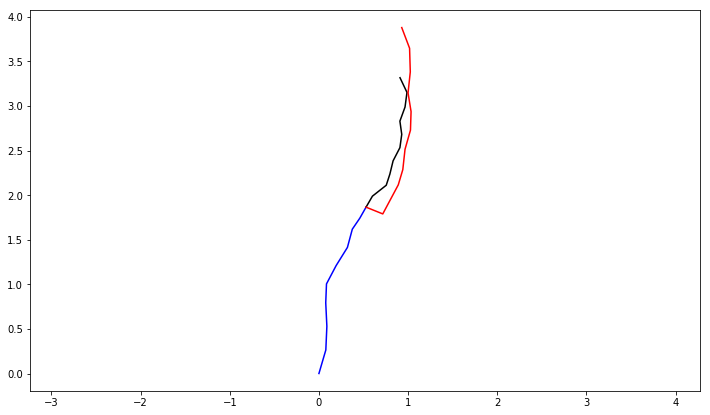

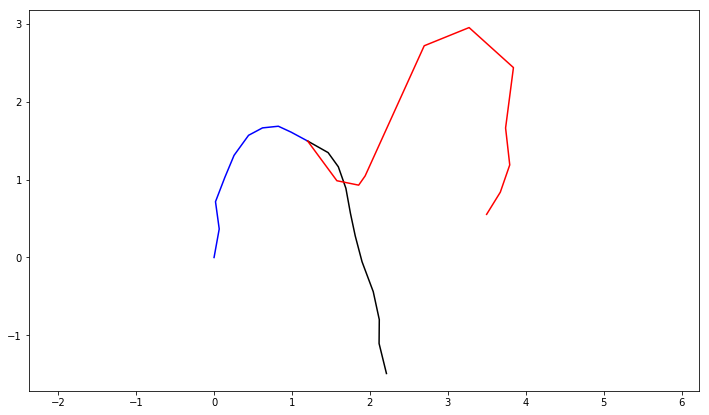

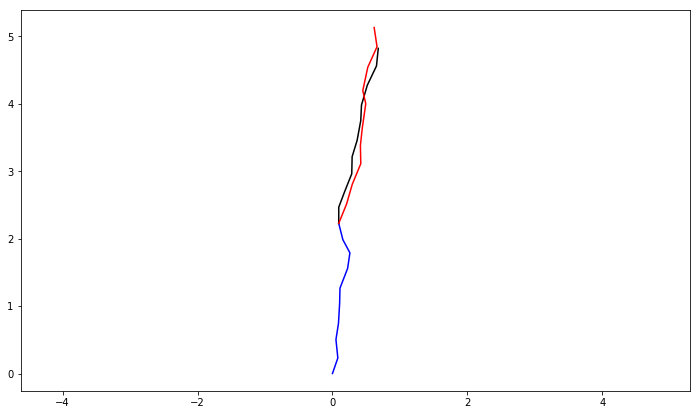

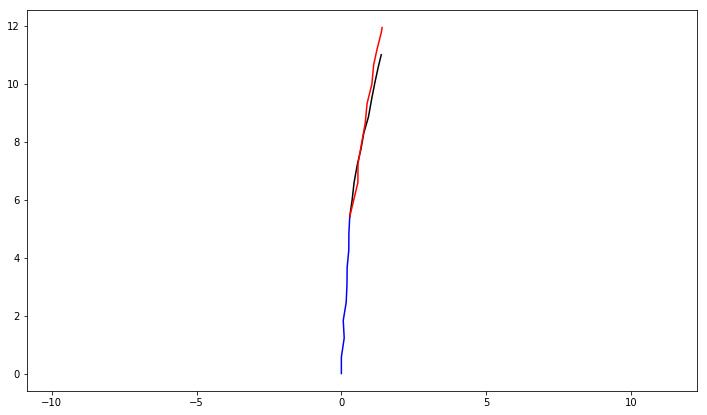

In [18]:
for i in range(20):
    plt.figure(figsize=(12, 7))

    plt.plot(in_coord[:,(i*20)+3000,0],in_coord[:,i*20+3000,1],c='b')
    plt.plot(gt_coord[:,i*20+3000,0],gt_coord[:,i*20+3000,1],c='k')
    plt.plot(output_coord[:,i*20+3000,0],output_coord[:,i*20+3000,1],c='r')
    plt.axis('equal')

In [ ]:
max_len = np.int(len(data['4000'])/20)
test = np.zeros([10,1,5*max_len])

In [ ]:
for i in range(max_len):
    test[:,0,i*4:(i+1)*4] = np.array(data['4000'].loc[i*10:(i+1)*10-1,'x':'Vy'])


In [ ]:
output_coord[1:,0,:]-output_final[:,0,0:2]

In [ ]:
dist = []
for i in range(len(data)):
    dist.append(sum(np.sqrt((output_coord[0,i,:]-output_coord[-1,i,:])**2)))

In [ ]:
np.std(dist),np.mean(dist)

In [ ]:
a = data['400']
infe = a.loc[0,'frameNb']
sup = a.loc[19,'frameNb']
a = a[a['frameNb']>=infe]
a = a[a['frameNb']<=sup]
a.index = range(len(a))

In [ ]:
a

In [ ]:
data['1']

In [ ]:
a = data['1'].loc[:,['frameNb','x','y','Vx','Vy']]

In [ ]:
a

In [ ]:
out.shape

In [ ]:
targets_test= targets[:,0,:]
out_test = out[:,0,:]

In [ ]:
los = criterion(out_test,targets_test)
los

In [ ]:
loss=((out_test-targets_test)**2).mean()

In [ ]:
(loss+los).backward()

In [ ]:
targets_test.shape

In [6]:
out_bis = out.clone()

NameError: name 'out' is not defined

In [ ]:
out_bis[0,0,0]=5

In [ ]:
out_bis